In [1]:
import bayes3d as b
import bayes3d.transforms_3d as t3d
import numpy as np 
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
from jax.debug import print as jprint
import physics_priors as p
import pose_update as u
import importlib
importlib.reload(p)
importlib.reload(u)
import time
import PIL.Image
from math import sqrt
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import plotly.graph_objects as go
%matplotlib inline 


/opt/conda/envs/bayes3d/lib/python3.9/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


In [2]:
def display_video(frames, framerate=30):
    if type(frames[0]) == PIL.Image.Image:
      frames = [np.array(frames[i]) for i in range(len(depths))]
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

In [3]:
intrinsics = b.Intrinsics(
    height=360,
    width=480,
    fx=180*sqrt(3), fy=180*sqrt(3),
    cx=240.0, cy=180.0,
    near=0.1, far=100.0
)
# intrinsics = b.Intrinsics(
#     height=300,
#     width=300,
#     fx=200.0, fy=200.0,
#     cx=150.0, cy=150.0,
#     near=0.001, far=6.0
# )

In [4]:
b.setup_renderer(intrinsics)
# b.RENDERER.add_mesh_from_file("assets/cube.obj",mesh_name="cube_0", scaling_factor=0.5)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (480, 384, 1024)


In [5]:
b.RENDERER.add_mesh_from_file("assets/cube.obj",mesh_name="cube_0", scaling_factor=[0.5,0.5,0.5])
b.RENDERER.add_mesh_from_file("assets/plane.obj",mesh_name="occluder", scaling_factor=[0.0667,0.0667,0.0667])

In [6]:
loaded_poses = np.load('scenario_test.npz')

In [7]:
occ_pose = loaded_poses['occ']
occ_pose[1:3] *= -1
occ_pose = jnp.array(occ_pose)

loaded_box_poses = loaded_poses['box']
gt_poses = []
occ_poses = []
for i in range(loaded_box_poses.shape[0]):
    pose = loaded_box_poses[i,...]
    pose[1:3] *= -1 # convert to CV2 convention (bayes3d currently assumes input is in cv2 coordinate frame)
    gt_poses.append(jnp.array(pose))
    occ_poses.append(occ_pose)
gt_poses = jnp.stack(gt_poses)
occ_poses = jnp.stack(occ_poses)

total_gt_poses = jnp.stack([gt_poses, occ_poses])

# cv2 convention of cam pose
cam_pose = loaded_poses['cam_pose']
world2cam = np.linalg.inv(cam_pose)
world2cam[1:3] *= -1
world2cam = jnp.array(world2cam)
cam_pose = jnp.linalg.inv(world2cam) 

In [8]:
# gt_images = jax.vmap(b.RENDERER.render_single_object, in_axes=(0, None))(gt_poses, jnp.int32(0))
gt_images = b.RENDERER.render_multiobject_parallel(total_gt_poses, [0,1])

# gt_images = jnp.stack([b.RENDERER.render_multiobject(
#     jnp.array([gt_poses[i], occ_pose]),
#     [0, 1]
# ) for i in range(gt_poses.shape[0])])



In [9]:
depths = [b.viz.get_depth_image(gt_images[i,:,:,2]) for i in range(gt_images.shape[0])]


In [10]:
# proposals = jnp.einsum("ij,ajk->aik", gt_poses[42], translation_deltas)
# prop_renders = b.RENDERER.render_multiobject_parallel(jnp.stack([proposals, occ_poses_trans]), jnp.array([0,1]))
# # scores = b.threedp3_likelihood_parallel(gt_images[42], prop_renders, 0.05, 0.1, 10**3, 3)
# print(b.threedp3_likelihood(gt_images[42], prop_renders[103], 0.05, 0.1, 10**3, 3))

In [11]:
display_video(depths)

In [89]:
dx, dy, dz = 0.15, 0.15, 0.15
translation_deltas = b.make_translation_grid_enumeration(-dx, -dy, -dz, dx, dy, dz, 5, 5, 5)


# dx, dy, dz = 2, 2, 2
# gridding = [
#     b.make_translation_grid_enumeration(
#         -dx, -dy, -dz, dx, dy, dz, 5,5,5
#     ),
#     b.make_translation_grid_enumeration(
#         -dx/2.0, -dy/2, -dz/2, dx/2, dy/2, dz/2, 5,5,5
#     ),
#     b.make_translation_grid_enumeration(
#         -dx/10.0, -dy/10, -dz/10, dx/10, dy/10, dz/10, 5,5,5
#     )
# ]



key = jax.random.PRNGKey(111)
rotation_deltas = jax.vmap(lambda key: b.distributions.gaussian_vmf(key, 0.00001, 800.0))(
    jax.random.split(key, 100)
)

pose_estimate = gt_poses[0]
occ_poses_trans = jnp.stack([occ_pose for _ in range(translation_deltas.shape[0])])
occ_poses_rot = jnp.stack([occ_pose for _ in range(rotation_deltas.shape[0])])

In [161]:
def update_pose_estimate(memory, gt_image):

    old_pose_estimate, prev_pose, T = memory

    threedp3_weight = 1
    proposals = jnp.einsum("ij,ajk->aik", old_pose_estimate, translation_deltas)
    rendered_images = b.RENDERER.render_multiobject_parallel(jnp.stack([proposals, occ_poses_trans]), jnp.array([0,1]))

    threedp3_scores = threedp3_weight * b.threedp3_likelihood_parallel(gt_image, rendered_images, 0.001, 0.1, 10**3, 3)
    unique_best_3dp3_score = jnp.sum(threedp3_scores == threedp3_scores[jnp.argmax(threedp3_scores)]) == 1

    physics_weight = jax.lax.cond(unique_best_3dp3_score, lambda _ : 0, lambda _ : 10000, None)

    physics_estimated_pose = p.physics_prior_v1_jit(old_pose_estimate, prev_pose, jnp.array([1,1,1]), cam_pose, world2cam)

    physics_scores = jax.lax.cond(jnp.greater(T, 1), 
    lambda _ : physics_weight * p.physics_prior_parallel_jit(proposals, physics_estimated_pose), 
    lambda _ : jnp.zeros(threedp3_scores.shape[0]), 
    None)

    scores = threedp3_scores + physics_scores

    pose_estimate = proposals[jnp.argmax(scores)]

    # pose_world = cam_pose @ pose_estimate
    # jprint("{}: {}, {}", T, unique_best_3dp3_score, pose_world[:,3])

    # proposals = jnp.einsum("ij,ajk->aik", pose_estimate, rotation_deltas)
    # rendered_images = b.RENDERER.render_multiobject_parallel(jnp.stack([proposals, occ_poses_rot]), jnp.array([0,1]))
    # weights_new = b.threedp3_likelihood_parallel(gt_image, rendered_images, 0.05, 0.1, 10**3, 3)
    # pose_estimate = proposals[jnp.argmax(weights_new)]

    return (pose_estimate, old_pose_estimate, T+1), pose_estimate
importlib.reload(p)


<module 'physics_priors' from '/home/ubuntu/bayes3d/experiments/physics/physics_priors.py'>

In [170]:
inference_program = jax.jit(lambda p,x: jax.lax.scan(
    update_pose_estimate, 
    (p,p,1),
    x)[1])

start = time.time()
inferred_poses = inference_program(gt_poses[0], gt_images)
end = time.time()
print ("Time elapsed:", end - start)
print ("FPS:", gt_poses.shape[0] / (end - start))

pred pos: [-2.4833472   0.          0.50007874]
pred pos: [-2.4833472   0.          0.50007874]
pred pos: [-2.3333471e+00  4.7683716e-07  5.0008005e-01]
pred pos: [-2.258347e+00 -9.536743e-07  5.000815e-01]
pred pos: [-2.1833470e+00 -4.7683716e-07  5.0008303e-01]
pred pos: [-2.1083469e+00 -1.4305115e-06  5.0008440e-01]
pred pos: [-2.183347e+00 -9.536743e-07  5.000843e-01]
pred pos: [-2.0333469e+00 -9.5367432e-07  5.0008583e-01]
pred pos: [-1.9583468e+00 -1.9073486e-06  5.0008732e-01]
pred pos: [-1.8833468e+00 -1.4305115e-06  5.0008887e-01]
pred pos: [-1.8083467e+00 -2.3841858e-06  5.0009006e-01]
pred pos: [-1.7333467e+00 -1.9073486e-06  5.0009161e-01]
pred pos: [-1.6583467e+00 -2.8610229e-06  5.0009298e-01]
pred pos: [-1.7333467e+00 -2.3841858e-06  5.0009304e-01]
pred pos: [-1.5833466e+00 -2.3841858e-06  5.0009441e-01]
pred pos: [-1.5083466e+00 -3.3378601e-06  5.0009590e-01]
pred pos: [-1.4333465e+00 -2.8610229e-06  5.0009733e-01]
pred pos: [-1.3583465e+00 -3.8146973e-06  5.0009871e-01

In [178]:
viz_images = []
max_depth = 10.0

inferred_poses_with_occ = jnp.stack([inferred_poses, occ_poses])

pred_images = b.RENDERER.render_multiobject_parallel(inferred_poses[None, ...], jnp.array([0]))
occ_image = b.viz.get_depth_image(b.RENDERER.render_single_object(occ_poses[0], 1)[:,:,2])

pred_with_occ_images = [b.overlay_image(b.viz.get_depth_image(pred_images[i,:,:,2]), 
occ_image, alpha=0.4) for i in range(pred_images.shape[0])]
# pred_images = b.RENDERER.render_multiobject_parallel(inferred_poses_with_occ, jnp.array([0,1]))

viz_images = [
    b.viz.multi_panel(
        [b.viz.get_depth_image(g[:,:,2]), b.viz.get_depth_image(p[:,:,2]), po],
        labels = ["Ground Truth", "Reconstruction w/o Occluder", "Reconstruction w Occluder"],
        title = "Physics Tracking Inference",
        # bottom_text = "3DP3 + Physics Prior v1"

    )
    for (g, p, po) in zip(gt_images, pred_images, pred_with_occ_images)
]
display_video(viz_images)


# labels=None, title=None, bottom_text=None, title_fontsize=40, label_fontsize=30,  bottom_fontsize=20, middle_width=10

In [175]:
rerendered_images.shape

(90, 360, 480, 4)

In [17]:
### DUMMY VALUES #########

translation_deltas = b.make_translation_grid_enumeration(-0.2, -0.2, -0.2, 0.2, 0.2, 0.2, 10, 10, 10)

# MANUALLY SPECIFY THESE
prev_prev_pose = jnp.array([[1., 0., 0., -0.1],
                        [0., 1., 0., 0.],
                        [0., 0., 1., 0.],
                        [0., 0., 0., 1.]])
prev_pose = jnp.array([[1., 0., 0., -0.0],
                        [0., 1., 0., 0.],
                        [0., 0., 1., 0.],
                        [0., 0., 0., 1.]])

best_pose = jnp.array([[1., 0., 0., 0.1],
                        [0., 1., 0., 0.],
                        [0., 0., 1., 0.],
                        [0., 0., 0., 1.]])


proposals = jnp.einsum("ij,ajk->aik", prev_pose, translation_deltas)
weights = physics_prior_v1_parallel(proposals, prev_pose, prev_prev_pose, jnp.array([1,1,1]), cam_pose, world2cam)
plot_physics_posterior(proposals, prev_pose, prev_prev_pose,weights, best_pose)

NameError: name 'plot_physics_posterior' is not defined

In [92]:
def plot_physics_posterior(proposals, pp, ppp, weights, best_pose = None):
    xs = np.asarray(proposals[:,0,3])
    ys = np.asarray(proposals[:,1,3])
    zs = np.asarray(proposals[:,2,3])

    prev = np.asarray(pp[:3,3])
    prev_prev = np.asarray(ppp[:3,3])    

    anns = [dict(
        showarrow=False,
        x=prev_prev[0],
        y=prev_prev[1],
        z=prev_prev[2],
        text="T-2",
        xanchor="left",
        xshift=5,
        opacity=0.7,
        font=dict(
            size=9  # Adjust the font size of the annotation
        )
    ),
    dict(
        showarrow=False,
        x=prev[0],
        y=prev[1],
        z=prev[2],
        text="T-1",
        xanchor="left",
        xshift=5,
        opacity=0.7,
        font=dict(
            size=9  # Adjust the font size of the annotation
        )
    )]

    pts = [go.Scatter3d(x=[prev_prev[0]],
                y=[prev_prev[1]],
                z=[prev_prev[2]],
                mode='markers',
                marker=dict(
                color='black',  # Specify the color values for each data point here
                size=2,
                symbol ='x'
                ),
            ),
    go.Scatter3d(x=[prev[0]],
                y=[prev[1]],
                z=[prev[2]],
                mode='markers',
                marker=dict(
                color='black',  # Specify the color values for each data point here
                size=2,
                symbol ='x'
                ),
            )]


    if best_pose != None:
        best = np.asarray(best_pose[:3,3])
        anns.append(dict(
                    showarrow=False,
                    x=best[0],
                    y=best[1],
                    z=best[2],
                    text="T-0 Best",
                    xanchor="left",
                    xshift=5,
                    opacity=0.7,
                    font=dict(
                        size=9  # Adjust the font size of the annotation
                    )
                ))
        pts.append( go.Scatter3d(x=[best[0]],
                    y=[best[1]],
                    z=[best[2]],
                    mode='markers',
                    marker=dict(
                    color='black',  # Specify the color values for each data point here
                    size=2,
                    symbol ='x'
                    ),
                ))

    fig = go.Figure(data=go.Volume(
        x=xs, y=ys, z=zs,
        value=np.asarray(weights),
        isomin=float(jnp.min(weights)),
        isomax=float(jnp.max(weights)),
        opacity=0.1,
        surface_count=25,
        ))
    fig.update_layout(title = 'Physics Posterior (Translation)',
                        scene_xaxis_showticklabels=True,
                    scene_yaxis_showticklabels=True,
                    scene_zaxis_showticklabels=True,
                    scene=dict(
            annotations=anns
        )
    )
    fig.add_traces(pts)

    fig.show()


In [94]:
ppp = jnp.around(cam_pose @ pose_estimates_over_time[29], 4)
pp = jnp.around(cam_pose @ pose_estimates_over_time[30], 4)
# translation_deltas = b.make_translation_grid_enumeration(-0.2, -0.2, -0.2, 0.2, 0.2, 0.2, 5, 5, 5)
proposals1 = jnp.einsum("ij,ajk->aik", pp, translation_deltas)
weights1 = physics_prior_v1_parallel(proposals1, pp, ppp, jnp.array([1,1,1]), cam_pose, world2cam)
plot_physics_posterior(proposals1, pp, ppp,weights1)


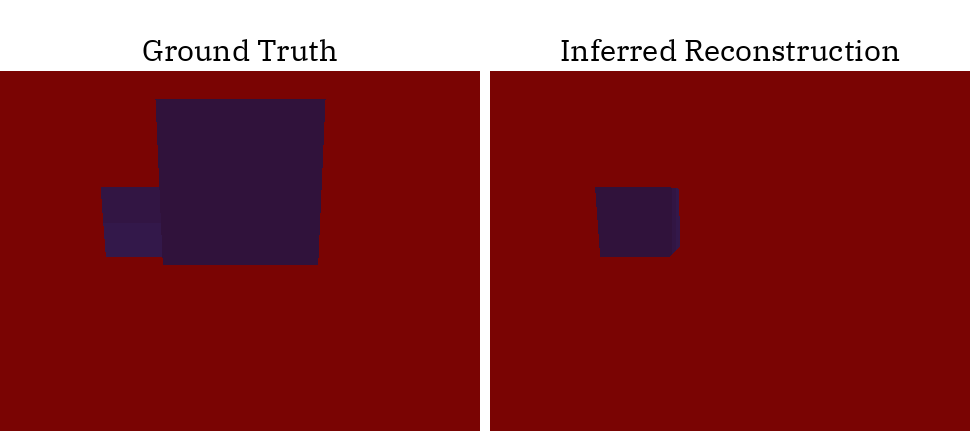

In [22]:
viz_images[16]